# Transistor de Benceno
1. En este ejemplo construiremos desde cero la geometría del sistema **electrodo-dispositivo-electrodo**, siendo el dispositivo (o canal) una molécula de benceno.
2. Una vez construida la gometría  crearemos los archivos de entrada para Transiesta para realizar un cálculo de la función de Green Fuera del Equilibrio (NEGF).
3. Después de obtener el hamiltoniano y la densidad electrónica con Transiesta podremos obtener la función de transmisión $T(E)$ con ayuda de Tbtrans
![](benzene_au_hcp32.png)
                                                                                            Omar HM

### Definición de parámetros de la celda unitaria del Electrodo
 1. Define los vectores de la red y sus vectores base.
 2. En este ejemplo se utiliza una red hcp de Au (arreglo ABA)

In [1]:
from pylab import *
import numpy as np
from mpl_toolkits.mplot3d import axes3d
#Define electrode Label:
label = "au_hcp" #ABA array
#Define lattice vectors:
a0 = 4.08
a1 = a0*np.array([1.0,0.0,0.0])
a2 = a0*np.array([0.0,1.0,0.0])
a3 = a0*np.array([0.0,0.0,1.0])
VolR = np.dot(a1,np.cross(a2,a3))
#Basis vectors (fractional if you want):
b1 = 0.0*a1 + 0.0*a2 + 0.0*a3
b2 = 0.0*a1 + 0.5*a2 + 0.5*a3
b3 = 0.5*a1 + 0.0*a2 + 0.5*a3
b4 = 0.5*a1 + 0.5*a2 + 0.0*a3
basis = [b1,b2,b3,b4]

### Creación de la supercelda para el electrodo:
1. Ejecuta la siguiente celda, te solicitará indicar el número de traslaciones en cada eje: para comenzar indica una traslación en cada eje.
2. Se creará un arreglo llamado **supercell_xyz** el cual contiene las coordenadas cartesianas de la supercelda del electrodo.
3. Se imprimira la distancia máxima en cada eje ya que serán de utilidad para hacer traslaciones y rotaciones de la molécula y los electrodos.
4. En adelante este notebook esta pensado para que la dirección semiinffinita sea a lo largo del eje X

In [2]:
ntraslationsx = int(input("Introduce las repeticiones en x:"))
ntraslationsy = int(input("Introduce las repeticiones en y:"))
ntraslationsz = int(input("Introduce las repeticiones en z:"))
np_lattice = (ntraslationsx+1)*(ntraslationsy+1)*(ntraslationsz+1) # Número de puntos en la supercelda
pointsR = np.zeros([np_lattice,3],dtype=np.float64)
count1 = 0
for n1 in range(0,int(ntraslationsx+1)):
  for n2 in range(0,int(ntraslationsy+1)):
    for n3 in range(0,int(ntraslationsz+1)):
      pointsR[count1,:] = n1*a1 + n2*a2 + n3*a3
      count1 = count1 + 1 
Natoms = np_lattice*len(basis)   # Número de átomos en la supercelda
supercell_xyz = np.zeros([Natoms,3],dtype=np.float64)
count2 = 0
for k in range(len(pointsR)):
  for l in range(len(basis)):
    supercell_xyz[count2,:]=pointsR[k] + basis[l]
    count2 = count2 + 1
print("System:" + "\t" + str(label) + 2*"\t"  + "\n"+ "Number of atoms:" + "\t" + str(Natoms) + "\t"+ "Vol. Cell:" + 1*"\t" +str("{:.2f}".format(VolR)))
xmax_sc, ymax_sc, zmax_sc = np.amax(supercell_xyz[:,0]), np.amax(supercell_xyz[:,1]), np.amax(supercell_xyz[:,2])
print("Max Supercell Distance in x:\t","{:.4f}".format(xmax_sc))
print("Max Supercell Distance in y:\t","{:.4f}".format(ymax_sc)) 
print("Max Supercell Distance in z:\t","{:.4f}".format(zmax_sc))

Introduce las repeticiones en x:1
Introduce las repeticiones en y:1
Introduce las repeticiones en z:1
System:	au_hcp		
Number of atoms:	32	Vol. Cell:	67.92
Max Supercell Distance in x:	 6.1200
Max Supercell Distance in y:	 6.1200
Max Supercell Distance in z:	 6.1200


### Lectura la geometría de la molécula (*device*) desde un archivo .xyz
 - Para este ejemplo se utilizo como *device* un anillo de benceno unido a dos átomos de azufre, lo cuales se unen covalentemente con el electrodo de Au.
 - Las coordenadas de la molécula se almacenarán en los arreglos `x_coord`, `y_coord` y `z_coord`.

In [4]:
def Readxyz(File):
    x,y,z    = loadtxt(File,usecols=(1,2,3),unpack=True,skiprows=2)
    atom     = loadtxt(File,usecols=(0,),unpack=True,skiprows=2,dtype="str")
    natoms   = len(x)
    Data     = {"label":File,
                "x":x,
                "y":y,
                "z":z,
                "atom":atom,
                "natoms":natoms}
    #print ("System: ", File)
    #print ("Número de átomos: {0}".format(natoms))
    #print ("Tipos de atomos:",unique(atom))
    return Data
###################################################################################################
molecule = Readxyz("s_benzene.xyz")
molecule_label = molecule["label"].replace(".xyz","")
Natoms2 = molecule["natoms"]
x_coord, y_coord, z_coord = molecule["x"], molecule["y"], molecule["z"]
atom_s = molecule["atom"]    
###################### Defining molecule midpoint as axis rotation ################################
xmax_mol, xmin_mol = np.amax(x_coord), np.amin(x_coord)
ymax_mol, ymin_mol = np.amax(y_coord), np.amin(y_coord)
zmax_mol, zmin_mol = np.amax(z_coord), np.amin(z_coord)
xm, ym, zm =  0.5*(xmax_mol+xmin_mol), 0.5*(ymax_mol+ymin_mol), 0.5*(zmax_mol+zmin_mol)
####################################################################################################

### A continuación se define una función que nos permitirá realizar rotaciones y traslaciones del device
1. La definición de variables de rotación y traslación se hacen en la siguiente celda
2. El punto medio de la molécula se utilizará para definir el eje de rotación de la molécula
3. En la siguiente función se define una rotación de la molécula en el plano xy, seguido de un rotación en el plano yz y por último una traslación, la cuál el usuario controlará en la siguiente sección.

In [5]:
def rotation_traslation(atom,anglexy,angleyz,xref,yref,zref,x_dis,y_dis,z_dis):
    anglexy = anglexy*math.pi/180
    angleyz = angleyz*math.pi/180
    #rotation xy-axis:
    xr = (x_coord[atom]-xref)*math.cos(anglexy) - (y_coord[atom]-yref)*math.sin(anglexy)
    yr = (x_coord[atom]-xref)*math.sin(anglexy) + (y_coord[atom]-yref)*math.cos(anglexy)
    #rotation yz-axis:
    yr = (z_coord[atom]-zref)*math.sin(angleyz) - (yr-yref)*math.cos(angleyz)
    zr = (z_coord[atom]-zref)*math.cos(angleyz) + (yr-yref)*math.sin(angleyz)
    #traslation
    xt = xr + x_dis
    yt = yr + y_dis
    zt = zr + z_dis
    return xt, yt, zt

### Definición de parámetros para la creación la región de scattering
1. Es muy importante hacer notar que la traslación mínima (en el eje x) de la molécula tiene que ser la suma del *tamaño de la supercelda con el tamaño de la molécula* las cuales se controlan con la variable **x_dis_mol = xmax_sc + abs(xmin_mol)**, esta distancia minima dejará la molécula "pegada" a la supercelda del eletrodo, por lo que es necesario hacer una traslación adicional al gusto del usuario.
2. A la par se definen los vectores de traslación (lattice vectors) que Transiesta utilizará para la conexión de la región de scattering con los electrodos

In [6]:
angle_rotationxy = 90 # zero for no rotation
angle_rotationyz = 0 # zero for no rotation
if angle_rotationxy !=0:
    xmin_mol, xmax_mol = ymax_mol, ymin_mol
################# x,y,z displacement for molecule ################
x_dis_mol = xmax_sc + abs(xmin_mol) + 2.3
y_dis_mol = ymax_sc/2
z_dis_mol = zmax_sc/2
# z displacement for the right electrode
x_dis_elec =  x_dis_mol + abs(xmax_mol) + 2.3
##################################################################
### Constructing the the lattice vetctors for leads conections ###
##################################################################
dev_lenght = xmax_sc + x_dis_elec # Device box lenght
a1_elec = [xmax_sc + a0/2, 0.0, 0.0]
a2_elec = [0.0,2.5*ymax_sc,0.0]
a3_elec = [0.0,0.0,3.5*zmax_sc]
a1_dev = [dev_lenght + a0/2, 0.0, 0.0]
a2_dev,a3_dev = a2_elec,a3_elec
print("THE NEXT LATTICE VECTORS WILL BE USED FOR YOUR ELECTRODE: \n")
print("cell=","{:.4f}".format(a1_elec[0]),"{:.4f}".format(a1_elec[1]),"{:.4f}".format(a1_elec[2]),"","{:.4f}".format(a2_elec[0]),"{:.4f}".format(a2_elec[1]),"{:.4f}".format(a2_elec[2]),"","{:.4f}".format(a3_elec[0]),"{:.4f}".format(a3_elec[1]),"{:.4f}".format(a3_elec[2]), "nsc= 1 1 1\n")
print("THE NEXT LATTICE VECTORS WILL BE USED FOR YOUR DEVICE: \n")
print("cell=","{:.4f}".format(a1_dev[0]),"{:.4f}".format(a1_dev[1]),"{:.4f}".format(a1_dev[2]),"","{:.4f}".format(a2_dev[0]),"{:.4f}".format(a2_dev[1]),"{:.4f}".format(a2_dev[2]), "","{:.4f}".format(a3_dev[0]),"{:.4f}".format(a3_dev[1]),"{:.4f}".format(a3_dev[2]), "nsc= 1 1 1")

THE NEXT LATTICE VECTORS WILL BE USED FOR YOUR ELECTRODE: 

cell= 8.1600 0.0000 0.0000  0.0000 15.3000 0.0000  0.0000 0.0000 21.4200 nsc= 1 1 1

THE NEXT LATTICE VECTORS WILL BE USED FOR YOUR DEVICE: 

cell= 25.2432 0.0000 0.0000  0.0000 15.3000 0.0000  0.0000 0.0000 21.4200 nsc= 1 1 1


### Creación de la región de Scattering
1. En esta sección se crea la geometría de la región de scattering en un archivo **.xyz**, verifica con un visualizador molecular cómo es esta región.
2. En este caso se está considerando el eje-x para la dirección semiinfinita.
3. A la par se crea la geometría del electrodo en un archivo **.xyz**, échale un ojo.
4. Es necesario que edites los vectores de traslación.

In [7]:
Natoms3 = 2*Natoms + Natoms2
res=open(str(label)+str(Natoms)+".xyz","w")
res.write(str(Natoms) + "\n")
res.write("cell= 8.1600 0.0000 0.0000  0.0000 15.3000 0.0000  0.0000 0.0000 21.4200 nsc= 1 1 1" + "\n")
res2 = open(str(label)+str(Natoms)+"_"+str(molecule_label)+".xyz","w")
res2.write(str(Natoms3) + "\n")
res2.write("cell= 25.2432 0.0000 0.0000  0.0000 15.3000 0.0000  0.0000 0.0000 21.4200 nsc= 1 1 1" + "\n")
for k in range(int(len(supercell_xyz))):
    res.write("Au" + "\t" + str("{:.4f}".format(supercell_xyz[k,0])) + "\t" +str("{:.4f}".format(supercell_xyz[k,1])) + "\t" +str("{:.4f}".format(supercell_xyz[k,2])) + "\n")
    res2.write("Au" + "\t" + str("{:.4f}".format(supercell_xyz[k,0])) + "\t" +str("{:.4f}".format(supercell_xyz[k,1])) + "\t" +str("{:.4f}".format(supercell_xyz[k,2])) + "\n")
for atom in range(Natoms2):
    xt,yt,zt = rotation_traslation(atom,angle_rotationxy,angle_rotationyz,xm,ym,zm,x_dis_mol,y_dis_mol,z_dis_mol)
    res2.write(str(atom_s[atom]) + "\t" + str("{:.4f}".format(xt)) + "\t" +str("{:.4f}".format(yt)) + "\t" +str("{:.4f}".format(zt)) + "\n")
for k in range(int(len(supercell_xyz))):
    res2.write("Au" + "\t" + str("{:.4f}".format(supercell_xyz[k,0]+x_dis_elec)) + "\t" +str("{:.4f}".format(supercell_xyz[k,1])) + "\t" +str("{:.4f}".format(supercell_xyz[k,2])) + "\n")
res.close()
res2.close()
print("Electrode geometry file:\t",str(label)+str(Natoms)+".xyz")
print("Device geometry file:\t",str(label)+str(Natoms)+"_"+str(molecule_label)+".xyz"+"\n")

Electrode geometry file:	 au_hcp32.xyz
Device geometry file:	 au_hcp32_s_benzene.xyz



### Creación de archivos .fdf con SISL
 - SISL will read cartesian coordinates from file.xyz both electrode and device.

In [8]:
import sisl

FileSyst = "au_hcp32_s_benzene.xyz"
FileElec = "au_hcp32.xyz"

SystemXYZ = sisl.io.xyzSile(FileSyst,mode='r')
System    = SystemXYZ.read_geometry()
System.write("STRUCT_DEVICE.fdf")
# uncomment if you want to check the structure:
System.write("STRUCT_DEVICE.xyz")

Elec_leftXYZ = sisl.io.xyzSile(FileElec,mode='r')
Elec_elec    = Elec_leftXYZ.read_geometry()
Elec_elec.write("STRUCT_ELEC.fdf")
Elec_elec.write("STRUCT_ELEC.xyz")
#Doble_left = Elec_left.tile(1,axis=0) 

### Conexión de los electrodos:
1. La intención de esta sección es verificar si los vectores de traslación (o de la red) son correctos.
2. Verifica si la periodicidad se mantiene, de lo contrario realiza las traslaciones necesarias para una conexión adecuada.
3.  Las posiciones de color rojo corresponden a los electrodos de lado izquierdo y derecho y las de color azul a la región de scattering.

In [9]:
Device = Readxyz("STRUCT_DEVICE.xyz")
Lead   = Readxyz("STRUCT_ELEC.xyz")

xD,yD,zD  = Device["x"],Device["y"],Device["z"]
xL,yL,zL  = Lead["x"]-a1_elec[0],\
            Lead["y"]-a1_elec[1],\
            Lead["z"]-a1_elec[2]
xR,yR,zR  = Lead["x"]+a1_dev[0],\
            Lead["y"]+a1_dev[1],\
            Lead["z"]+a1_dev[2]

maximo = array( [xD.max(),yD.max(),zD.max(),
                 xL.max(),yL.max(),zL.max(),
                 xR.max(),yR.max(),zR.max()] ).max()
minimo = array( [xD.min(),yD.min(),zD.min(),
                 xL.min(),yL.min(),zL.min(),
                 xR.min(),yR.min(),zR.min()] ).min()

import ipyvolume as ipv
ipv.figure()
s = ipv.scatter(xL, yL, zL, marker='sphere', size=3)
s = ipv.scatter(xD, yD, zD, marker='sphere', size=3,color="blue")
s = ipv.scatter(xR, yR, zR, marker='sphere', size=3)
ipv.xyzlim(minimo, maximo)
ipv.show()

## Cálculos con Transiesta
Hasta este punto ya deberías tener los archivos **STRUCT_ELEC.fdf** y **STRUCT_DEVICE.fdf** los cuales contienen la geometría y vectores de traslación del electrodo y de la zona de scattering en un formato que puede ser leído por TranSIESTA.
1. El primer paso es obtener el archivo **ELEC.TSHS** el cual contiene la información estructural y del Hamiltoniano del electrodo, para ello es necesario correr un cálculo de convencional de SIESTA con la opción **TS.HS.Save** se encuentre activa (opción *true*). Para este paso ya previamente se debio haber realizado un estudio de convergencia del electrodo en cuestión, así que ejecuta:

    `siesta RUN_ELEC.fdf > RUN_ELEC.out`  
    
    una vez que terminó el cálculo verifica que sí se haya generado el archivo **ELEC.TSHS**.
    
2.  Ahora sí, llegó la hora de iniciar el cálculo de Transiesta en equilibrio $V=0$, para ello ve a la carpeta **TS_0**, y copia los pseudopontenciales:

    `cd TS_0`
    
    `cp ../*psf .`
3. Para ejecutar el cálculo de Transiesta escribe:

    `siesta ../RUN.fdf > RUN.out`

    si las conexiones de la región de scattering con los electrodos es correcta se iniciará los ciclos de convergencia SCF.
    

4. Cuando finalice el cálculos se obtendrán los siguientes archivos:

   - **siesta.TSHS** el cual contiene información geométrica y del hamiltoniano de la región de scattering y que será utilizado por TBtrans para el cálculo de propiedades físicas.
   - **siesta.TSDE** Este archivo contiene información de la matriz densidad y de la energía que será de utilidad para cálculos fuera del equilibrio $V \neq 0$.
   - **siesta.TSGF*** Contiene información de las autoenergías de ocupadas en el acoplamiento de los electrodos.

## Cálculo de la función de Transmisión $T(E)$
En esta sección haremos uso de **TBtrans** y de la paquetería **sisl** para obtener la función de Transmisión. TBtrans necesita la información geométrica y del Hamiltoniano de los electrodos y de la región de scattering, contenidos en **ELEC.TSHS** y **siesta.TSHS**, previamente generados. Así que puedes ejecutar:

    `tbtrans RUN_TBT.fdf > RUN_TBT.out`

1. Tienes que hacer una labor de convergencia del número de puntos *k*, pero inicia con un número pequeño.
2. Al terminar el cálculo obtendrás el archivo **siesta.TBT.nc** el cual contiene información de la función y de las propiedades que dependenda de ella. 
3. En el archivo **RUN_TBT.fdf** revisa qué opciones se le solicitaron a TBtrans que calculara. Revisa el manual para ver todas las opciones que tiene y así puedas obtener la que tu desees.
4. Ahora haremos uso de **sisl** para extraera la información del archivo **.nc* y con ello gráficar la transmisión:

In [11]:
tbt = sisl.get_sile('siesta.TBT.nc')
print(tbt.info())

Device information:
  - number of kpoints: 25 <- [ A = 1 , B = 5 , C = 5 ] (time-reversal unknown)
  - energy range:
     -9.99500 -- 9.99500 eV  [10.000 meV]
  - imaginary part (eta): 0.0000 meV
  - atoms with DOS (1-based):
     33-40
  - number of BTD blocks: 2
  + DOS Green function: true
  - Density matrix Green function: false                    [TBT.DM.Gf]
  - COOP Green function: false                              [TBT.COOP.Gf]
  - COHP Green function: false                              [TBT.COHP.Gf]

Electrode: Left
  - number of BTD blocks: 3
  - Bloch: [1, 1, 1]
  - chemical potential: 0.0000 eV
  - electron temperature: 299.99 K
  - imaginary part (eta): 0.1000 meV
  + DOS bulk: true
  + DOS spectral: true
  + orbital-current: true
  - Density matrix spectral: false                          [TBT.DM.A]
  - COOP spectral: false                                    [TBT.COOP.A]
  - COHP spectral: false                                    [TBT.COHP.A]
  + transmission bulk: true
 

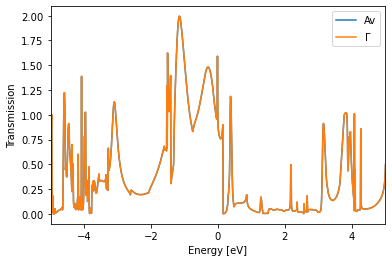

In [12]:
#Gráfica de la función de Transmisión
plt.plot(tbt.E, tbt.transmission(),label='Av');
plt.plot(tbt.E, tbt.transmission(kavg=tbt.kindex([0,0,0])), label=r'$\Gamma$'); plt.legend()
plt.ylabel('Transmission'); plt.xlabel('Energy [eV]'); plt.xlim([-5,5]);

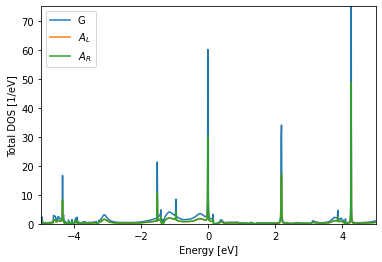

In [13]:
#Gráfica de la densidad de estados
DOS_all = [tbt.DOS(), tbt.ADOS(0), tbt.ADOS(1)]
plt.plot(tbt.E, DOS_all[0], label='G');
plt.plot(tbt.E, DOS_all[1], label=r'$A_L$');
plt.plot(tbt.E, DOS_all[2], label=r'$A_R$');
plt.xlim([-5,5]);plt.ylim([0, 75]); plt.ylabel('Total DOS [1/eV]'); plt.xlabel('Energy [eV]'); plt.legend(); 

## Calculos fuera del Equilibrio $V\neq0$
Hasta ahora sólo hemos realizado cálculos en el equilibrio $V=0$, ahora realizaremos cálculos aplicando una diferencia de potencial $V$, el cual desplazará el nivel de fermi de los electrodos a $\pm V/2$. Se empleará el archivo **.TSDE** de cálculos previos para ayudar el proceso de convergencia e cada $V$ aplicado.

1. Estando en la carpeta TS_0 copia el archivo **siesta.TSDE** a la carpeta TS_0.25:

    `cp siesta.TSDE ../TS_0.25`
    `cd ../TS_0.25`
2. Copia los archivos de los pseudopotenciales: `cp ../*psf .`
3. Estando dentro de la carpeta TS_0.25 realiza el cálculo de Transiesta fuera del equilibrio, pero para que ya no hagas cambios del voltaje dentro del archivo RUN.fdf, puedes ejecutar de la siguiente manera:
    
    `siesta  -V 0.25:eV ../RUN.fdf > RUN.out`
   
4. Realiza el mismo procedimiento para los demás valores de $V$, 0.5, 0.75 y 1.0:
    ````
    cp siesta.TSDE ../TS_0.5
    cd ../TS_0.5 
    cp ../*psf .
    siesta  -V 0.5:eV ../RUN.fdf > RUN.out
    cp siesta.TSDE ../TS_0.75`
    cd ../TS_0.75 
    cp ../*psf .
    siesta  -V 0.75:eV ../RUN.fdf > RUN.out
    ````
    etcétera.